#### About

Using effnet model.

augmentation uses sca and standard augmentations + invert. 

Validation data has no augmentations

In [1]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 80
nb_classes = 100                     # move to 1. step
#input_shape = (32, 20,1)            # will be calculated
Batch_Size = 32
use_grayscale = True                # grayscale or rgb
model_filename = "resnet.h5"

############################ augmentation ###############################

Shift_Range = 1 # px
Brightness_Range = [0.4,0.9]
Rotation_Angle = 3
ZoomRange_Out = 0.1
ZoomRange_In = 0.1
ShearRange= 2
Channel_Shift=0.2

########################### data paths ##################################


tmnist_dir = 'datasets'
ziffer_dir = 'images'

In [2]:
import sys
import os

### for kaggle the input paths must be changed
if (os.path.exists('/kaggle/input/between2numbers/')):
    package_paths = [
        '/kaggle/input/between2numbers/',
    ]

    for pth in package_paths:
        sys.path.append(pth)

    tmnist_dir = '/kaggle/input/between2numbers/datasets'
    ziffer_dir = '/kaggle/input/between2numbers/images'

#### 

### Load data

Like the distillation network meter digits will be trained with font builded images.

The meter digits are all 0-9 ziffer_raw + my own data 0-9. 
At now no images used between two digits. Many images from 0-9 are +/- 0.2 devergent and not correctly labeled. (See the last result)

Ziffer data count:  6146
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-05-23 23:16:46.097704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-23 23:16:46.097837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


dataset x_data-size=278666


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


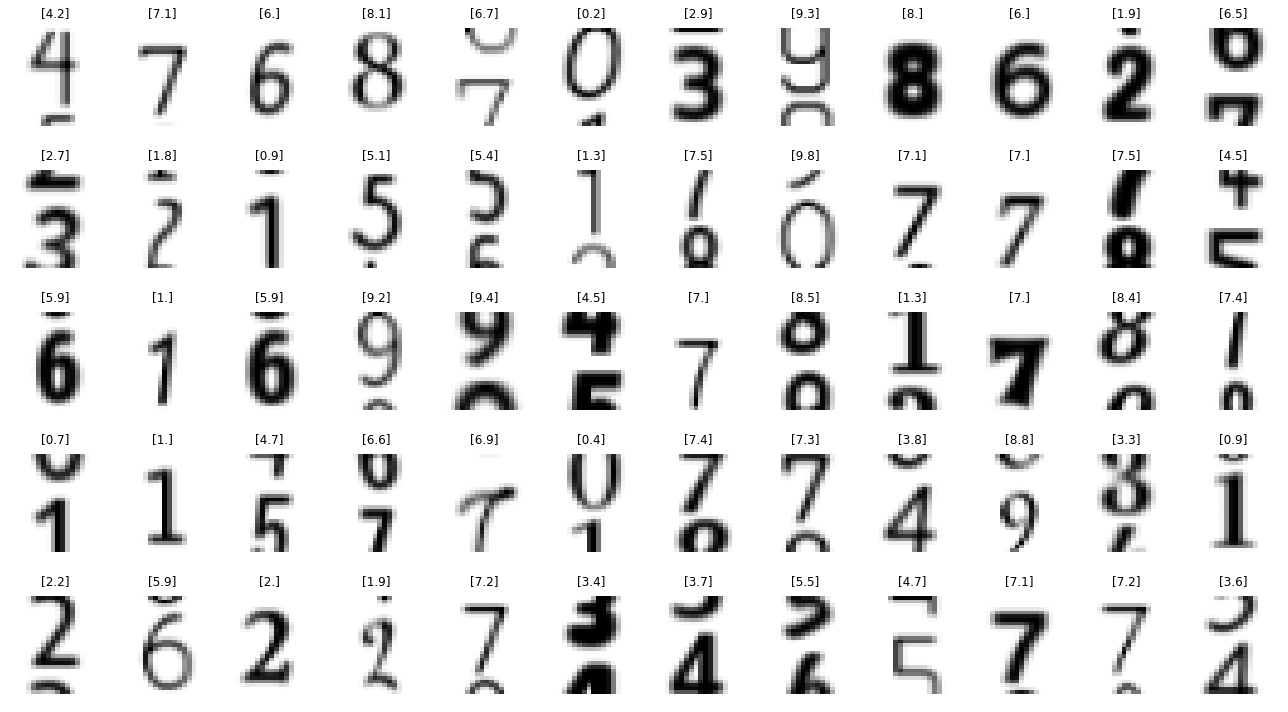

In [3]:
from b2n.data.ziffer import ziffer_data
from b2n.data.tmnist import tmnist_percentals
from sklearn.utils import shuffle
from b2n.plotfunctions import plot_dataset
from b2n.encodings.class_encoding import class_encoding
import numpy as np

xz_data, yz_data, fz_data = ziffer_data(ziffer_dir, use_grayscale=use_grayscale)


x_data, y_data = tmnist_percentals(tmnist_dir, use_grayscale=use_grayscale)
x_data = np.concatenate((x_data, xz_data))
y_data = np.concatenate((y_data, yz_data))
x_data, y_data = shuffle(x_data, y_data)

input_shape=x_data[0].shape
print(f"dataset x_data-size={len(x_data)}")
plot_dataset(x_data, y_data)

y_data = class_encoding(y_data, nb_classes)

### Augmentation
See augementation above for augmentation values.
Standard augmentation of image generator is used plus inverting images.

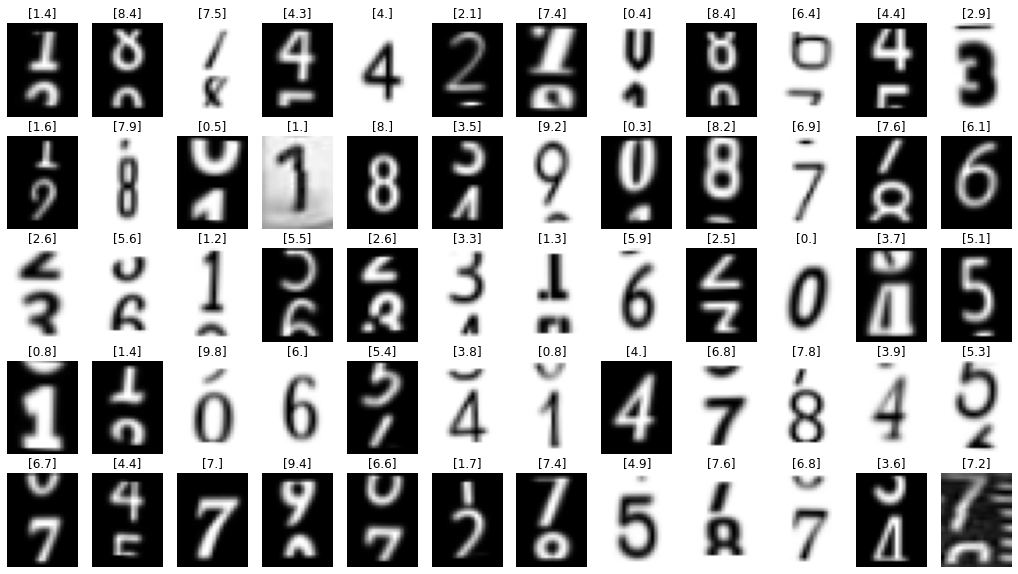

In [4]:
from sklearn.model_selection import train_test_split
from b2n.augmentation.generator import augmentation, augmentation_validation
from b2n.plotfunctions import plot_dataset_it

augmentations={"Width_Shift_Range" : .2,
            "Height_Shift_Range" : .1,
            "Brightness_Range" : [0.4,1.5],
            "Rotation_Angle": 3,
            "ZoomRange_Out" : 0.1,
            "ZoomRange_In" : 0.1,
            "ShearRange" : 2,
            "Channel_Shift" : 0.2,
            "zca_whitening" : True
}

# Split train and validation data 
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)

train_iterator = augmentation(x_train, y_train, augmentations=augmentations, Batch_Size=Batch_Size)
validation_iterator = augmentation_validation(x_test, y_test)

plot_dataset_it(train_iterator)       


### The Model

Is an small EfficientNet like model with a dense output of 100 at top. 

In [5]:
import tensorflow as tf
from b2n.models.effnet import Effnet

model = Effnet(input_shape, nb_classes, activation_top=None)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

In [7]:
from tensorflow.keras.callbacks import LearningRateScheduler
from b2n.plotfunctions import plot_acc_loss

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.96 ** x, verbose=0)

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                callbacks=[annealer],
                verbose=1)

plot_acc_loss(history, "Trainingsresults")

model.save(model_filename)

Epoch 1/80
6967/6967 [==============================] - ETA: 0s - loss: 1.2650 - accuracy: 0.7165

2022-05-23 23:25:55.064913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6967/6967 [==============================] - 545s 78ms/step - loss: 1.2650 - accuracy: 0.7165 - val_loss: 0.3591 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 2/80
6967/6967 [==============================] - 568s 82ms/step - loss: 0.2416 - accuracy: 0.9336 - val_loss: 0.1237 - val_accuracy: 0.9640 - lr: 9.6000e-04
Epoch 3/80
 786/6967 [==>...........................] - ETA: 7:41 - loss: 0.1927 - accuracy: 0.9459

KeyboardInterrupt: 

### Verfify the training

Now a few (5000) images from validation set will be used to evaluate the model.

All the first (max 30) false predicted images will be shown.

If all fine the predictions will be shown in a diagram and it should be a sinus and cosinus wave. The glitches are the false predictions.

In [ ]:
import numpy as np
from b2n.encodings.class_encoding import class_decoding
from b2n.plotfunctions import plot_divergence, plot_dataset

res = []
stat_Anz = []
stat_Abweichung = []
false_img = []
false_label = []
test_count = 5000

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for x_test, y_test in validation_iterator:
    if (test_count<0):
        break
    test_count = test_count - Batch_Size
           
    for (x, y) in zip(x_test, y_test):
            
        target = class_decoding([y])
        classes = model.predict(np.expand_dims(x.reshape(input_shape), axis=0))
        
        
        out_target = class_decoding(classes)[0]

                       
        if target != out_target:
            lbl_text = "Expected: " + str(target) + "\n Predicted: " + str(out_target)
            print("Exp: " + str(target) + " Pred: " + str(out_target))
            false_img.append(x)
            false_label.append(lbl_text)
    
for i in range(100):
    if (stat_Anz[i] != 0):
        stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res
print(f"{len(false_label)} false predicted")
plot_dataset(np.array(false_img), false_label, columns=11, rows=4)



### Ziffer images

The model is build for predicting meter digit images (Ziffer). So we test *all* meter digit images of the dataset (not only the validation set)

max_delta can set a value, that ignored convergence +/- of the value and accept it as predicted correctly.

Because of the meter digit dataset (only 0.0, 1.0, ... 9.0) We have no real answer how good the images between two digits are predicted.

In [ ]:
import numpy as np
from b2n.encodings.class_encoding import class_decoding
from b2n.plotfunctions import plot_divergence, plot_dataset

res = []
stat_Abweichung = np.zeros(nb_classes)
false_img = []
false_label = []
max_delta = 0.11

def isclose(a, b, delta):
    return min(abs(a-b),abs(a-(10-b)))<=delta


for x, y, filename in zip(xz_data, yz_data, fz_data):

    target = y
    classes = model.predict(np.expand_dims(x.reshape(input_shape), axis=0))
    out_target = class_decoding(classes)[0]
    res.append(out_target)
                   
    if not isclose(target, out_target, max_delta) :
        lbl_text = "Expected: " + str(target) + "\n Predicted: " + str(out_target) + "\n" + filename[0][:-4]
        #print("Exp: " + str(target) + " Pred: " + str(out_target))
        false_img.append(x)
        false_label.append(lbl_text)
        stat_Abweichung[int(abs(target-out_target)*10)] = stat_Abweichung[int(abs(target-out_target)*10)]+1
        # move image to failure_dir 
        #move_to_failure_dir(filename[0])


print(f"Tested images: {len(yz_data)}. {len(false_label)} false predicted. Accuracy is: {1-len(false_label)/len(yz_data)}")
plot_divergence(stat_Abweichung, "Divergation of false predicted", nb_classes)
#print(confusion_matrix(np.asarray(res), yz_data, nb_classes))
plot_dataset(np.array(false_img), false_label, columns=8, rows=5, figsize=(18,16))